In [1]:
import pickle

import numpy as np
import datetime

import joblib
import torch

from utils import *
from model import LSTM

def get_patient_data(data, time, SpellID_Anon):
    all_patients = data[data['AreaSequence'] == 1]['SpellID_Anon'].values
    data = data[data['SpellID_Anon'].isin(all_patients)]
    data = data[(data['StartTime'] <= time) & (
        data['SpellID_Anon'] == SpellID_Anon)]

    data['Pathway'] = (data['Pathway'] != 'Walkin').astype('category')

    with open('dict_area.pkl', 'rb') as f:
        dict_area = pickle.load(f)
    data['CurrentArea'] = data['CurrentArea'].map(dict_area) - 1

    data = data.sort_values(by='AreaSequence')
    now = data[(data['StartTime'] <= time) & (
        data['EndTime'] >= time)]
    now_area_sequence = now['AreaSequence'].values[0]
    now_area = now['CurrentArea'].values[0]

    Pathway = data['Pathway'].values[0]
    FirstTimetoED = pd.Timestamp(
        data[data['AreaSequence'] == 1]['StartTime'].values[0])
    FirstTimetoED_cal = FirstTimetoED.hour + FirstTimetoED.minute/60

    patient = [Pathway, FirstTimetoED_cal]

    current_areas = data['CurrentArea'].values
    start_times = data['StartTime'].values
    total_mins = data['TotalMins'].values

    for i in range(1, now_area_sequence*2+1):
        if i % 2 == 1:
            patient.append(current_areas[i//2])
        else:
            if current_areas[i//2 - 1] == now_area:
                timedelta = time - pd.to_datetime(start_times[i//2-1])
                minutes = timedelta.total_seconds() / 60
                patient.append(minutes)
            else:
                patient.append(total_mins[i//2-1])
    for i in range(3, len(patient), 2):
        if patient[i] == 0:
            patient[i-1] += patient[i+1]
            del patient[i]
            del patient[i]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    patient = np.array(patient)
    region_sequences = torch.IntTensor(patient[2:-1:2]).to(device)
    time_sequences = torch.FloatTensor(
        patient[3::2]/patient[3::2].max() if patient[3::2].max() != 0 else patient[3::2]).to(device)
    other_features = patient[:2]

    extractor = LSTM().to(device)
    extractor.load_state_dict(torch.load('models/lstm_xgb/lstm.pth'))
    extractor.eval()
    with torch.no_grad():
        region_embed = extractor.region_embedding(region_sequences)
        time_embed = extractor.time_embedding(
            region_sequences) * time_sequences.unsqueeze(-1)
        combined_embed = torch.cat([region_embed, time_embed], dim=-1)
        _, (hidden, _) = extractor.lstm(combined_embed.float())
        extracted_features = hidden.squeeze(0).cpu().numpy()
    extracted_features = np.concatenate(
        [other_features, extracted_features])
    extracted_features = extracted_features.reshape(1, -1)
    classifier = joblib.load('models/lstm_xgb/xgb.dta')
    predict_proba = classifier.predict_proba(
        extracted_features)[:, 1][0]
    temp = {
        'id': SpellID_Anon,
        'predict_proba': predict_proba
    }
    return temp

In [2]:
def patient_isadmitted(data):
    col = ['SpellID_Anon'] + ['isAdmitted']

    patients = pd.DataFrame(columns=col)

    # encode the first time to ED
    patients[['SpellID_Anon']
             ] = data[data['AreaSequence'] == 1][['SpellID_Anon']]

    # encode the admitted status
    transfer_status_list = pd.Series(data['TransferStatus'].unique())
    uch_list = transfer_status_list[~transfer_status_list.isin(
        ['Arrival-Discharge', 'Arrival', 'Discharged', 'Transfer'])]
    patient_admitted_list = data[data['TransferStatus'].isin(uch_list)]
    patients['isAdmitted'] = patients['SpellID_Anon'].isin(
        patient_admitted_list['SpellID_Anon']).astype(int)
    return patients

In [3]:
hour = 24
pred_beds_list = []
act_beds_list = []
time = pd.to_datetime('2019-06-01 00:00:00')
data = pd.read_csv('AE_Visit_example5k.csv')
all_patients = data[data['AreaSequence'] == 1]['SpellID_Anon'].values
data = data[data['SpellID_Anon'].isin(all_patients)]
data['StartTime'] = pd.to_datetime(
    data['StartTime'], format='%d/%m/%Y %H:%M')
data['EndTime'] = pd.to_datetime(data['EndTime'], format='%d/%m/%Y %H:%M')
time_intervals = [time + datetime.timedelta(minutes=n) for n in range(0, hour*60, 5)]
def get_interval_data(interval):
    now_patients = data[(data['StartTime'] <= interval) & (data['EndTime'] >= interval)]
    temp_list = [get_patient_data(data, interval, patient) for patient in now_patients['SpellID_Anon'].values]
    patients = patient_isadmitted(data)
    pred_beds = sum(temp['predict_proba'] for temp in temp_list)
    patients_id = [temp['id'] for temp in temp_list]
    act_beds = patients[patients['SpellID_Anon'].isin(patients_id)]['isAdmitted'].sum()
    return pred_beds, act_beds
pred_beds_list, act_beds_list = zip(*[get_interval_data(interval) for interval in time_intervals])

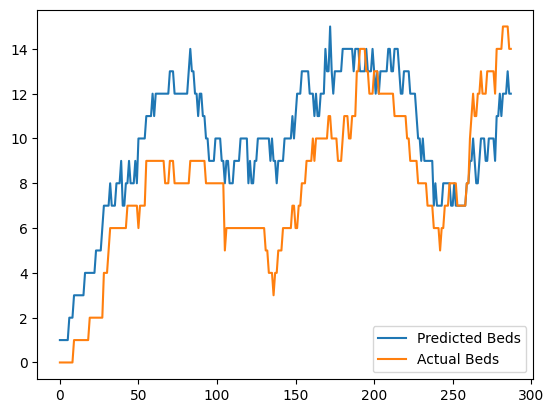

In [4]:
import matplotlib.pyplot as plt
pred_beds_list = np.ceil(pred_beds_list)
plt.plot(pred_beds_list, label='Predicted Beds')
plt.plot(act_beds_list, label='Actual Beds')
plt.legend()
plt.show()

In [5]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(act_beds_list, pred_beds_list)
mae

2.4930555555555554

In [6]:
from scipy import spatial
cos_sim = 1 - spatial.distance.cosine(act_beds_list, pred_beds_list)
cos_sim

0.9716672902954715